# Ein Hybridmodell mit LSTM-AE, DBSCAN und IF

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import classification_report
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import logging
from tensorflow.keras.layers import TimeDistributed, Dense, LSTM, Dropout, LayerNormalization, Input, Add, Bidirectional, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import balanced_accuracy_score
import sys
from keras.layers import LSTM, Dropout, LayerNormalization, Add, TimeDistributed, Dense
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from tensorflow.keras import backend as K

2025-07-22 18:53:04.659001: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753203184.679331  140225 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753203184.686733  140225 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753203184.703170  140225 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753203184.703204  140225 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753203184.703206  140225 computation_placer.cc:177] computation placer alr

## 1. Vorbereitung

In [2]:
import torch
print(torch.cuda.is_available())          # Sollte True sein
print(torch.cuda.get_device_name(0))      # Quadro K1100M

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
Quadro K1100M


/home/ueay/bachelorarbeit-projekt/env/lib/python3.12/site-packages/torch/cuda/__init__.py:262: UserWarning: 
    Found GPU0 Quadro K1100M which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(


In [3]:
from sklearn.model_selection import StratifiedKFold

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [4]:
# from dotenv import load_dotenv
# import requests
# import os

# event_url = os.environ.get("EVENT_URL")

# def get_all_events(token):
#     headers = {'Authorization': f'Bearer {token}'}
#     all_events = []
#     resp = requests.get(event_url, headers=headers)
#     resp.raise_for_status()
#     batch = resp.json()
#     all_events.extend(batch)

#     return all_events

# server_url = os.environ.get("URL")
# client_id = os.environ.get("CLIENT_ID")
# client_secret = os.environ.get("CLIENT_SECRET")
# token_url = os.environ.get("TOKEN_URL")
# keycloak_url = os.environ.get("keycloak_url")
# authRealm = os.environ.get("authRealm")
# realm = os.environ.get("realm")

# load_dotenv()

# def get_token():
#     data = {
#         'keycloak_url': keycloak_url,
#         'authRealm': authRealm,
#         'realm': realm,
#         'client_id': client_id,
#         'client_secret': client_secret,
#         'grant_type': 'client_credentials'
#         }
#     resp = requests.post(token_url, data=data)
#     resp.raise_for_status()
#     token = resp.json()['access_token']
#     return token

# token = get_token()
# events = get_all_events(token)

In [5]:
# from datetime import datetime
# import json


# filename = datetime.now().strftime("keycloak_events_%Y-%m-%d.jsonl")
# with open(filename, "a") as f:
#     for event in events:
#         f.write(json.dumps(event) + "\n")

#### Daten laden

In [6]:
data_train = pd.read_json("train-data.jsonl", lines=True)
data_test = pd.read_json("test-data.jsonl", lines=True)
data_val = pd.read_json("val-data.jsonl", lines=True)
print(data_test.head())

            time           type                               realmId  \
0  1753198345374          LOGIN  92af0a1e-2b57-4893-bf9a-f7e163fde560   
1  1753111595780  CODE_TO_TOKEN  2419ba72-8f52-44e4-834b-0fdb3b774d96   
2  1753111595608          LOGIN  2419ba72-8f52-44e4-834b-0fdb3b774d96   
3  1753198342851          LOGIN  92af0a1e-2b57-4893-bf9a-f7e163fde560   
4  1753198340334          LOGIN  92af0a1e-2b57-4893-bf9a-f7e163fde560   

                 clientId                                userId  \
0                nintendo  4e945e9f-1882-446e-ad47-a9c89ec922c1   
1  security-admin-console  c1205ab6-65de-4383-a059-aefe88c5b088   
2  security-admin-console  c1205ab6-65de-4383-a059-aefe88c5b088   
3                nintendo  4e945e9f-1882-446e-ad47-a9c89ec922c1   
4                nintendo  4e945e9f-1882-446e-ad47-a9c89ec922c1   

                              sessionId  ipAddress  \
0  4a374bc1-8133-4d84-bcf5-29901c69b8b8  127.0.0.1   
1  8d0ef520-302d-4f74-a3b5-7ddd3bfe79dd  127.0.0.1

In [7]:
X_train_full = pd.DataFrame(data_train)
X_test_full = pd.DataFrame(data_test)
X_val_full = pd.DataFrame(data_val)

data_test['label'] = data_test['details'].apply(lambda x: x.get('label', None))
data_val['label'] = data_val['details'].apply(lambda x: x.get('label', None))
y_test_full = data_test["label"]
y_val_full = data_val["label"]

#### Automatisch alles in Numerische oder Kategorische Daten einteilen

In [8]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def is_missing(val):
    return val is None or (isinstance(val, float) and np.isnan(val))

def flatten_log_entry(log, parent_key='', sep='.'):
    items = []
    for k, v in log.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_log_entry(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

def auto_encode_features(logs, one_hot_numeric=False, label_encoders=None, onehot_encoders=None, fit=True):
    # Logs flach machen
    flat_logs = [flatten_log_entry(log) for log in logs]

    if label_encoders is None:
        label_encoders = {}
    if onehot_encoders is None:
        onehot_encoders = {}

    # Encoder vorbereiten
    for key in flat_logs[0].keys():
        values = []
        for log in flat_logs:
            val = log.get(key)

            if is_missing(val):
                val = "__MISSING__"
            elif isinstance(val, (list, dict)):
                print(f"Feature '{key}' enthält nicht-skalaren Wert – wird als String gespeichert: {val}")
                val = str(val)

            values.append(val)

        if fit:
            try:
                le = LabelEncoder()
                le.fit(values)
                label_encoders[key] = le
            except Exception as e:
                print(f"Fehler beim Enkodieren von Feature '{key}': {e}")
                continue

    # Feature-Werte transformieren
    encoded_logs = []
    for log in flat_logs:
        encoded_log = {}
        for key, le in label_encoders.items():
            val = log.get(key, "__MISSING__")
            if is_missing(val):
                val = "__MISSING__"
            elif isinstance(val, (list, dict)):
                val = str(val)
            try:
                encoded_log[key] = le.transform([val])[0]
            except ValueError:
                encoded_log[key] = -1  # unbekannte Kategorie
        encoded_logs.append(encoded_log)

    return encoded_logs, label_encoders, onehot_encoders


#### Werte aus vorheriger Funktion vereinigen

In [9]:
def dicts_to_feature_matrix(encoded_logs):
    feature_names = sorted({key for d in encoded_logs for key in d.keys()})

    X = np.zeros((len(encoded_logs), len(feature_names)), dtype=np.float32)

    for i, d in enumerate(encoded_logs):
        for j, feat in enumerate(feature_names):
            if feat in d:
                X[i, j] = d[feat]

    return X, feature_names

In [10]:
logs_train = X_train_full.to_dict(orient='records')
#logs_train = events
logs_test = X_test_full.to_dict(orient='records')
logs_val = X_val_full.to_dict(orient='records')

encoded_logs, label_encoders, onehot_encoders = auto_encode_features(
    logs_train, one_hot_numeric=False, fit=True
)
X_train, feature_names = dicts_to_feature_matrix(encoded_logs)

encoded_test_logs, _, _ = auto_encode_features(
    logs_test, one_hot_numeric=False,
    label_encoders=label_encoders, onehot_encoders=onehot_encoders, fit=False
)
X_test, _ = dicts_to_feature_matrix(encoded_test_logs)

encoded_val_logs, _, _ = auto_encode_features(
    logs_val, one_hot_numeric=False,
    label_encoders=label_encoders, onehot_encoders=onehot_encoders, fit=False
)
X_val, _ = dicts_to_feature_matrix(encoded_val_logs)

#### Skalierung

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

### Parameter

In [ ]:
seq_length = 5
batch_size = 32

encoder_layers = [64, 32]
decoder_layers = [32,64]

dropout_rate = 0.0
learning_rate = 0.0001

### Sequenzen

In [13]:
class SequenceToSequenceGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, seq_length, batch_size, pad_last=True):
        self.data = data
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.pad_last = pad_last

        self.indices = np.arange(len(data) - seq_length)
        
        # Wenn Padding aktiv ist und etwas übrig bleibt
        if pad_last and (len(data) % seq_length != 0):
            self.include_last = True
        else:
            self.include_last = False

    def __len__(self):
        base = (len(self.indices) + self.batch_size - 1) // self.batch_size
        return base + (1 if self.include_last else 0)

    def __getitem__(self, idx):
        if idx < len(self) - 1 or not self.include_last:
            batch_idx = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
            X_batch = np.array([self.data[i:i + self.seq_length] for i in batch_idx])
        else:
            # letzte Sequenz mit Padding
            last_seq = self.data[-self.seq_length:]
            if len(last_seq) < self.seq_length:
                padding_len = self.seq_length - len(last_seq)
                padding = np.zeros((padding_len, self.data.shape[1]))
                last_seq = np.vstack((last_seq, padding))
            X_batch = np.expand_dims(last_seq, axis=0)

        return X_batch, X_batch

train_gen = SequenceToSequenceGenerator(X_train_scaled, seq_length, batch_size)
val_gen = SequenceToSequenceGenerator(X_val_scaled, seq_length, batch_size)
test_gen = SequenceToSequenceGenerator(X_test_scaled, seq_length, batch_size)

## 2. LSTM-AE implementieren

In [14]:
def residual_lstm_block(inputs, units, dropout_rate=dropout_rate):
    shortcut = inputs
    x = LSTM(units, return_sequences=True)(inputs)
    x = Dropout(dropout_rate)(x)
    x = LayerNormalization()(x)

    if K.int_shape(shortcut)[-1] != units:
        shortcut = TimeDistributed(Dense(units))(shortcut)

    x = Add()([x, shortcut])
    return x

n_features = X_train_scaled.shape[1]

inputs = Input(shape=(seq_length, n_features))
x = inputs

# Tieferer Encoder
for units in encoder_layers:
    x = residual_lstm_block(x, units, dropout_rate)

encoded = Bidirectional(LSTM(encoder_layers[-1]))(x)

# Tieferer Decoder
x = RepeatVector(seq_length)(encoded)
for units in decoder_layers:
    x = residual_lstm_block(x, units, dropout_rate)

outputs = TimeDistributed(Dense(n_features, activation='linear'))(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate), loss='mse')
model.summary()

I0000 00:00:1753203189.501505  140225 gpu_device.cc:2383] Ignoring visible gpu device (device: 0, name: Quadro K1100M, pci bus id: 0000:01:00.0, compute capability: 3.0) with Cuda compute capability 3.0. The minimum required Cuda capability is 3.5.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5, 12)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 5, 1024)   │  4,247,552 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 5, 1024)   │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 5, 1024)   │      2,048 │ dropout[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 5, 1024)   │     13,312 │ input_layer[0][0] │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 5, 1024)   │          0 │ layer_normalizat… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 5, 256)    │  1,311,744 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 5, 256)    │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 256)    │        512 │ dropout_1[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 5, 256)    │    262,400 │ add[0][0]         │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 5, 256)    │          0 │ layer_normalizat… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 5, 32)     │     36,992 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 5, 32)     │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 32)     │         64 │ dropout_2[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 5, 32)     │      8,224 │ add_1[0][0]       │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 5, 32)     │          0 │ layer_normalizat… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 64)        │     16,640 │ add_2[0][0]       │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 5, 64)     │          0 │ bidirectional[0]… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 5, 32)     │     12,416 │ repeat_vector[0]

 Total params: 11,743,436 (44.80 MB)

 Trainable params: 11,743,436 (44.80 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[early_stop])

Epoch 1/10


/home/ueay/bachelorarbeit-projekt/env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 2.4135 - val_loss: 17.3016
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 613ms/step - loss: 0.9236 - val_loss: 16.7598
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 399ms/step - loss: 0.7201 - val_loss: 16.6485
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 374ms/step - loss: 0.9162 - val_loss: 16.8731
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step - loss: 0.3952 - val_loss: 16.8270
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step - loss: 0.4360 - val_loss: 16.6917
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step - loss: 0.4514 - val_loss: 16.9349
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 388ms/step - loss: 0.5880 - val_loss: 16.9749


### Umwandlung der Daten für nächste Modelle: Rekonstruktionsfehler berechnen

In [16]:
def get_reconstruction_errors(gen, model):
    errors = []
    for i in range(len(gen)):
        X_batch, _ = gen[i]
        pred = model.predict(X_batch, verbose=0)
        batch_errors = np.mean(np.square(X_batch - pred), axis=(1, 2))
        errors.extend(batch_errors)
    return np.array(errors)

train_errors = get_reconstruction_errors(train_gen, model)
val_errors = get_reconstruction_errors(val_gen, model)
test_errors = get_reconstruction_errors(test_gen, model)

reconstruction_errors = get_reconstruction_errors(test_gen, model)
threshold = np.percentile(train_errors, 99)

In [17]:
y_test_seq = np.array([y_test_full[i + seq_length - 1] for i in range(len(reconstruction_errors))])
true_labels = y_test_seq.astype(int)

fpr, tpr, thresholds = roc_curve(true_labels, reconstruction_errors)
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]
y_pred = (reconstruction_errors > optimal_threshold).astype(int)

precision, recall, f1, _ = precision_recall_fscore_support(true_labels, y_pred, average='binary')
roc_auc = roc_auc_score(true_labels, reconstruction_errors)
#logging.info(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1-Score: {f1:.3f}, ROC-AUC: {roc_auc:.3f}")
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1-Score: {f1:.3f}, ROC-AUC: {roc_auc:.3f}")

Precision: 0.500, Recall: 0.667, F1-Score: 0.571, ROC-AUC: 0.905


In [18]:
scaler_rec = StandardScaler()
scaler_rec.fit(train_errors.reshape(-1, 1))
val_errors_scaled = scaler_rec.transform(val_errors.reshape(-1, 1))
test_errors_scaled = scaler_rec.transform(test_errors.reshape(-1, 1))

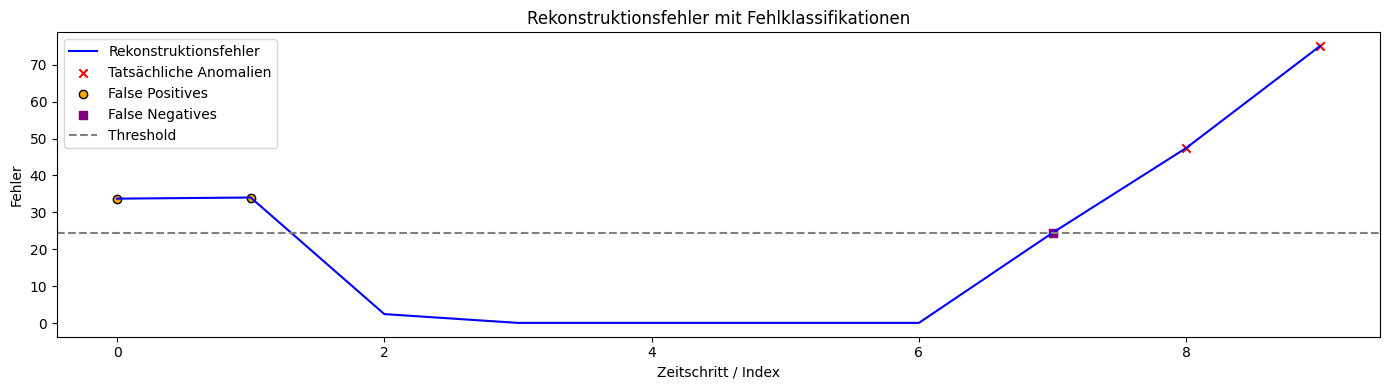

In [19]:
plt.figure(figsize=(14, 4))
plt.plot(reconstruction_errors, label="Rekonstruktionsfehler", color="blue")

plt.scatter(
    np.where(true_labels == 1)[0],
    reconstruction_errors[true_labels == 1],
    color="red", label="Tatsächliche Anomalien", marker="x"
)

false_positives = (y_pred == 1) & (true_labels == 0)
plt.scatter(
    np.where(false_positives)[0],
    reconstruction_errors[false_positives],
    color="orange", label="False Positives", marker="o", edgecolors='k'
)

false_negatives = (y_pred == 0) & (true_labels == 1)
plt.scatter(
    np.where(false_negatives)[0],
    reconstruction_errors[false_negatives],
    color="purple", label="False Negatives", marker="s"
)

plt.axhline(optimal_threshold, color='gray', linestyle='--', label="Threshold")
plt.legend()
plt.title("Rekonstruktionsfehler mit Fehlklassifikationen")
plt.xlabel("Zeitschritt / Index")
plt.ylabel("Fehler")
plt.tight_layout()
plt.show()

# Modell 1

## Isolation Forest

In [20]:
iforest = IsolationForest()
iforest.fit(train_errors.reshape(-1, 1))

test_preds_if = iforest.predict(test_errors.reshape(-1, 1))
val_anomaly_if = (test_preds_if == -1).astype(int)

y_test_seq_if = np.array([y_test_full[i + seq_length- 1] for i in range(len(val_anomaly_if))])
true_labels_if = y_test_seq_if.astype(int)

report_iforest_if = classification_report(true_labels_if, val_anomaly_if)
#logging.info("Isolation Forest - Test Report:\n" + report_iforest_if)
print("Isolation Forest - Test Report:\n" + report_iforest_if)

Isolation Forest - Test Report:
              precision    recall  f1-score   support

           0       1.00      0.57      0.73         7
           1       0.50      1.00      0.67         3

    accuracy                           0.70        10
   macro avg       0.75      0.79      0.70        10
weighted avg       0.85      0.70      0.71        10



### IF MCC

In [21]:
mcc_if = matthews_corrcoef(true_labels_if, val_anomaly_if)
print("Matthews Correlation Coefficient: ", mcc_if)

Matthews Correlation Coefficient:  0.5345224838248488


### IF Balanced Accuracy

In [22]:
balanced_acc = balanced_accuracy_score(true_labels_if, val_anomaly_if)
print("Balanced Accuracy: ", balanced_acc)

Balanced Accuracy:  0.7857142857142857


### IF AUC-Kurven

In [23]:
val_scores = -iforest.decision_function(val_errors.reshape(-1,1))
y_val_seq = np.array([y_val_full[i + seq_length - 1] for i in range(len(val_scores))])
true_labels = y_val_seq.astype(int)

fpr, tpr, _ = roc_curve(true_labels, val_scores)
roc_auc = roc_auc_score(true_labels, val_scores)

precision, recall, _ = precision_recall_curve(true_labels, val_scores)
pr_auc = average_precision_score(true_labels, val_scores)

/tmp/ipykernel_140225/528637419.py:3: RuntimeWarning: invalid value encountered in cast
  true_labels = y_val_seq.astype(int)


ValueError: multiclass format is not supported

In [ ]:
plt.figure(figsize=(12, 5))

# ROC Plot
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation)")
plt.legend()
plt.tight_layout()
plt.savefig('roc_curve_if.png', dpi=300)
plt.close()
plt.show()

In [ ]:
# PR Plot
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"AP = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Validation)")
plt.legend()
plt.tight_layout()
plt.savefig('pr_curve_if.png', dpi=300)
plt.close()
plt.show()

# Modell 2

## One-Class SVM

In [ ]:
ocsvm = OneClassSVM(nu=0.005, gamma=50)
ocsvm.fit(train_errors.reshape(-1, 1))

test_preds_ocsvm = ocsvm.predict(test_errors.reshape(-1, 1))
test_anomaly_ocsvm = (test_preds_ocsvm == -1).astype(int)

y_test_seq_ocsvm = np.array([y_test_full[i + seq_length - 1] for i in range(len(test_anomaly_ocsvm))])
true_labels_ocsvm = y_test_seq.astype(int)

report_ocsvm = classification_report(true_labels_ocsvm, test_anomaly_ocsvm)
#logging.info("One-Class SVM - Test Report:\n" + report_ocsvm)
print("One-Class SVM - Test Report:\n" + report_ocsvm)

### OCSVM MCC

In [ ]:
mcc = matthews_corrcoef(true_labels_ocsvm, test_anomaly_ocsvm)
#logging.info("Matthews Correlation Coefficient: %f", mcc)
print("Matthews Correlation Coefficient:", mcc)

### OCSVM Balanced Accuracy

In [ ]:
balanced_acc = balanced_accuracy_score(true_labels_ocsvm, test_anomaly_ocsvm)
#logging.info("Balanced Accuracy: %f", balanced_acc)
print("Balanced Accuracy: ", balanced_acc)

### OCSVM AUC-Kurven

In [ ]:
val_scores_ocsvm = -ocsvm.decision_function(val_errors.reshape(-1,1))
y_val_seq_ocsvm = np.array([y_val_full[i + seq_length - 1] for i in range(len(val_scores_ocsvm))])
true_labels_ocsvm = y_val_seq_ocsvm.astype(int)

fpr, tpr, _ = roc_curve(true_labels_ocsvm, val_scores_ocsvm)
roc_auc = roc_auc_score(true_labels_ocsvm, val_scores_ocsvm)

precision, recall, _ = precision_recall_curve(true_labels_ocsvm, val_scores_ocsvm)
pr_auc = average_precision_score(true_labels_ocsvm, val_scores_ocsvm)
# Plotten
plt.figure(figsize=(12, 5))

# ROC OCSVM
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation)")
plt.legend()
plt.tight_layout()
plt.savefig('roc_curve_ocsvm.png', dpi=300)
plt.close()
plt.show()

# PR OCSVM
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"AP = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Validation)")
plt.legend()
plt.tight_layout()
plt.savefig('pr_curve_ocsvm.png', dpi=300)
plt.close()
plt.show()

# Modell 3

## DBSCAN

In [ ]:
dbscan = DBSCAN(eps = 0.05, min_samples = 40)

dbscan_labels = dbscan.fit_predict(test_errors.reshape(-1, 1))
dbscan_anomaly = (dbscan_labels == -1).astype(int)

y_test_seq_dbscan = np.array([y_test_full[i + seq_length - 1] for i in range(len(dbscan_anomaly))])
true_labels_dbscan = y_test_seq_dbscan.astype(int)
#logging.info("\n" + classification_report(true_labels_dbscan, dbscan_anomaly))
print("\n" + classification_report(true_labels_dbscan, dbscan_anomaly))

### DBSCAN MCC

In [ ]:
mcc = matthews_corrcoef(true_labels_dbscan, dbscan_anomaly)
#logging.info("Matthews Correlation Coefficient: %f", mcc)
print("Matthews Correlation Coefficient: %f", mcc)

### DBSCAN Balanced Accuracy

In [ ]:
balanced_acc = balanced_accuracy_score(true_labels_dbscan, dbscan_anomaly)
#logging.info("Balanced Accuracy: %f", balanced_acc)
print("Balanced Accuracy: %f", balanced_acc)

### DBSCAN AUC-Kurven

In [ ]:
scores = dbscan_anomaly

fpr, tpr, _ = roc_curve(true_labels_dbscan, scores)
roc_auc = roc_auc_score(true_labels_dbscan, scores)

precision, recall, _ = precision_recall_curve(true_labels_dbscan, scores)
pr_auc = average_precision_score(true_labels_dbscan, scores)
plt.figure(figsize=(12, 5))

In [ ]:
# ROC-Kurve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (DBSCAN)")
plt.legend()
plt.savefig('roc_curve_dbscan.png', dpi=300)
plt.close()
plt.show()

In [ ]:
# PR-Kurve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"AP = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (DBSCAN)")
plt.legend()
plt.tight_layout()
plt.savefig('pr_curve_dbscan.png', dpi=300)
plt.close()
plt.show()

## Cross Validation Test

### Für LSTM-AE und IF

In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import IsolationForest
import numpy as np

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

all_precisions, all_recalls, all_f1s, all_roc_aucs = [], [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_test_full)):
    print(f"Fold {fold + 1}/{n_splits}")

    model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[early_stop], verbose=0)

    iforest = IsolationForest()
    iforest.fit(train_errors.reshape(-1, 1))

    test_preds_if = iforest.predict(test_errors.reshape(-1, 1))
    val_anomaly_if = (test_preds_if == -1).astype(int)

    y_test_seq_if = np.array([y_test_full[i + seq_length- 1] for i in range(len(val_anomaly_if))])
    true_labels_if = y_test_seq_if.astype(int)

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, y_pred, average='binary')
    roc_auc = roc_auc_score(true_labels, iforest.decision_function(test_errors.reshape(-1, 1)) * -1)

    all_precisions.append(precision)
    all_recalls.append(recall)
    all_f1s.append(f1)
    all_roc_aucs.append(roc_auc)

print(f"Mean Precision: {np.mean(all_precisions):.3f} ± {np.std(all_precisions):.3f}")
print(f"Mean Recall: {np.mean(all_recalls):.3f} ± {np.std(all_recalls):.3f}")
print(f"Mean F1-Score: {np.mean(all_f1s):.3f} ± {np.std(all_f1s):.3f}")
print(f"Mean ROC-AUC: {np.mean(all_roc_aucs):.3f} ± {np.std(all_roc_aucs):.3f}")

### Für LSTM-AE und OCSVM

In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import IsolationForest
import numpy as np

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

all_precisions, all_recalls, all_f1s, all_roc_aucs = [], [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_test_full)):
    print(f"Fold {fold + 1}/{n_splits}")

    model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[early_stop], verbose=0)
    ocsvm = OneClassSVM(nu=0.005, gamma=50)
    ocsvm.fit(train_errors.reshape(-1, 1))

    test_preds_ocsvm = ocsvm.predict(test_errors.reshape(-1, 1))
    test_anomaly_ocsvm = (test_preds_ocsvm == -1).astype(int)

    y_test_seq_ocsvm = np.array([y_test_full[i + seq_length - 1] for i in range(len(test_anomaly_ocsvm))])
    true_labels_ocsvm = y_test_seq.astype(int)

    report_ocsvm = classification_report(true_labels_ocsvm, test_anomaly_ocsvm)

    all_precisions.append(precision)
    all_recalls.append(recall)
    all_f1s.append(f1)
    all_roc_aucs.append(roc_auc)

print(f"Mean Precision: {np.mean(all_precisions):.3f} ± {np.std(all_precisions):.3f}")
print(f"Mean Recall: {np.mean(all_recalls):.3f} ± {np.std(all_recalls):.3f}")
print(f"Mean F1-Score: {np.mean(all_f1s):.3f} ± {np.std(all_f1s):.3f}")
print(f"Mean ROC-AUC: {np.mean(all_roc_aucs):.3f} ± {np.std(all_roc_aucs):.3f}")

### Für LSTM-AE und DBSCAN

In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import IsolationForest
import numpy as np

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

all_precisions, all_recalls, all_f1s, all_roc_aucs = [], [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_test_full)):
    print(f"Fold {fold + 1}/{n_splits}")

    model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[early_stop], verbose=0)
    dbscan = DBSCAN(eps = 0.05, min_samples = 40)

    dbscan_labels = dbscan.fit_predict(test_errors.reshape(-1, 1))
    dbscan_anomaly = (dbscan_labels == -1).astype(int)

    y_test_seq_dbscan = np.array([y_test_full[i + seq_length - 1] for i in range(len(dbscan_anomaly))])
    true_labels_dbscan = y_test_seq_dbscan.astype(int)
    
    all_precisions.append(precision)
    all_recalls.append(recall)
    all_f1s.append(f1)
    all_roc_aucs.append(roc_auc)

print(f"Mean Precision: {np.mean(all_precisions):.3f} ± {np.std(all_precisions):.3f}")
print(f"Mean Recall: {np.mean(all_recalls):.3f} ± {np.std(all_recalls):.3f}")
print(f"Mean F1-Score: {np.mean(all_f1s):.3f} ± {np.std(all_f1s):.3f}")
print(f"Mean ROC-AUC: {np.mean(all_roc_aucs):.3f} ± {np.std(all_roc_aucs):.3f}")